In [ ]:
import numpy as np
from numpy import pi

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile

# Qiskit AerSimulator import
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2

# Transiplation/optimization ISA
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns

#Simulator
simulator = AerSimulator()


Parametrized circuit:


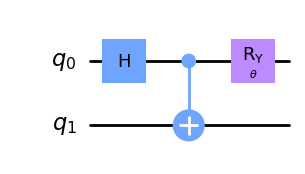

In [ ]:
# ╔══════════════════════════════════╗
# ║ 1. PARAMETRIZED CIRCUIT BUILDING ║
# ╚══════════════════════════════════╝

theta = Parameter("$\\theta$")
qc = QuantumCircuit(2)

# Bell state preparation |Φ⁺⟩
qc.h(0)
qc.cx(0, 1)

# Parametrized rotation
qc.ry(theta, 0)

print("\nParametrized circuit:")
qc.draw(output="mpl", idle_wires=False, style="clifford", filename="IBM_Torino_qc_param.svg")

In [ ]:
# ╔════════════════════════════════════════════╗
# ║ 2. TEST - CHECK BELL STATE PREPARATION     ║
# ╚════════════════════════════════════════════╝
'''
#The errors could be related to a non-correct Bell state preparation!

# "statevector" simulation method
simulator = AerSimulator(method="statevector")

# Fixing paramether value
bound_circuit = qc.assign_parameters({theta: 0})

# Statevector saving
bound_circuit.save_statevector()

# Job execution
job = simulator.run(bound_circuit, shots=1)
result = job.result()

#Print result (Bell state expected)
statevector = result.get_statevector(bound_circuit)
print("Resulting statevector:", statevector)
'''

'\n#The errors could be related to a non-correct Bell state preparation!\n\n# "statevector" simulation method\nsimulator = AerSimulator(method="statevector")\n\n# Fixing paramether value\nbound_circuit = qc.assign_parameters({theta: 0})\n\n# Statevector saving\nbound_circuit.save_statevector()\n\n# Job execution\njob = simulator.run(bound_circuit, shots=1)\nresult = job.result()\n\n#Print result (Bell state expected)\nstatevector = result.get_statevector(bound_circuit)\nprint("Resulting statevector:", statevector)\n'

In [ ]:
# ╔════════════════════════════════════════════╗
# ║ 3. OBSERVABLE DEFINITION - PHASES CREATION ║
# ╚════════════════════════════════════════════╝
# CHSH1 =  Z\otimes Z  - Z\otimes X  + X\otimes Z  + X\otimes X
# CHSH2 =  Z\otimes Z  + Z\otimes X  - X\otimes Z  + X\otimes X
chsh1 = SparsePauliOp.from_list([("ZZ", +1), ("ZX", -1), ("XZ", +1), ("XX", +1)])
chsh2 = SparsePauliOp.from_list([("ZZ", +1), ("ZX", +1), ("XZ", -1), ("XX", +1)])

num_phases = 30
phases = np.linspace(0, 2 * np.pi, num_phases)

# Every "binding" for EstimatorV" must be a single value list [θ_k]
param_bindings = [[th] for th in phases]  # e.g. [[0], …, [2π]]

OrderedDict([('h', 1), ('cx', 1), ('ry', 1)])


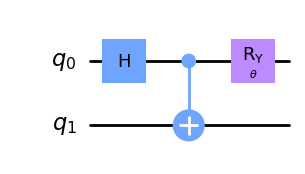

In [ ]:
# ╔══════════════════════════════════════════════════════════╗
# ║ 4. ISA OPTIMIZATION (transpiler) ON PARAMETRIZED CIRCUIT ║
# ╚══════════════════════════════════════════════════════════╝

target = simulator.target

basis_gates = ["rz","sx","cx","id"]
chsh_transpiled = transpile(qc,
                            optimization_level=3,
                            basis_gates=basis_gates,
                            seed_transpiler=42)
chsh_transpiled.draw(output="mpl", idle_wires=False, style="iqp")
plt.show()

# pass manager - opt_lvl=3
pm = generate_preset_pass_manager(target=target, optimization_level=3)

#Parametrized circuit application (results with adapted Aer gates - θ kept)
qc_isa = pm.run(qc)
print(qc_isa.count_ops())
qc_isa.draw(output="mpl", idle_wires=False, style="clifford", filename="AER_qc_circuit.svg")


In [ ]:
# ╔═════════════════════════════════════════════╗
# ║ 5. SINGLE "pub" ESTIMATORV2 - JOB EXECUTION ║
# ╚═════════════════════════════════════════════╝

est = EstimatorV2()
est.options.resilience_level = 2
est.options.default_shots = 100000

pub = (
    qc_isa,
    [[chsh1], [chsh2]],
    param_bindings
)

job = est.run(pubs=[pub])
res = job.result()

data_bin = res._pub_results[0].data   # get DataBin obj
evs_array = data_bin.evs              # get array values, shape = (2, num_phases)
chsh1_est = evs_array[0, :]           # CHSH1 for each binding
chsh2_est = evs_array[1, :]           # CHSH2 for each bindings
print("CHSH1 values:", chsh1_est)
print("CHSH2 values:", chsh2_est)

CHSH1 values: [ 2.          1.52330023  0.97537264  0.3818377  -0.22955154 -0.83020721
 -1.39204331 -1.88878901 -2.29721704 -2.59822975 -2.77775213 -2.8273899
 -2.74482207 -2.5339094  -2.20451395 -1.77203788 -1.25670328 -0.68260664
 -0.07659207  0.53300387  1.11767713  1.65008905  2.10534464  2.46215666
  2.70384097  2.81909668  2.80253456  2.65492904  2.38318199  2.        ]
CHSH2 values: [ 2.          2.38318199  2.65492904  2.80253456  2.81909668  2.70384097
  2.46215666  2.10534464  1.65008905  1.11767713  0.53300387 -0.07659207
 -0.68260664 -1.25670328 -1.77203788 -2.20451395 -2.5339094  -2.74482207
 -2.8273899  -2.77775213 -2.59822975 -2.29721704 -1.88878901 -1.39204331
 -0.83020721 -0.22955154  0.3818377   0.97537264  1.52330023  2.        ]


In [ ]:
# ╔════════════════════════════╗
# ║ 6. S PARAMETER COMPUTATION ║
# ╚════════════════════════════╝

S_values = np.maximum(np.abs(chsh1_est), np.abs(chsh2_est))
S_max = np.max(S_values)

S_mean = np.mean(S_values)
S_std = np.std(S_values, ddof=1)

print("\n" + "═"*26)
print("CHSH Results:")
print("═"*26)
print("S parameters for each binding:", S_values)
print(f"Maximum Bell violation (S_max): {S_max:.4f}")
# Mean and standard dev
print(f"S mean value: {S_mean:.4f} ± {S_std:.4f}")

# ╔═════════════════════════════╗
# ║ 7. CRYTICAL ANALYSIS RESULT ║
# ╚═════════════════════════════╝
print("\n" + "═"*26)
print("Critical analysis results")
print("═"*26)
print(f"1. Inequality violation: {S_max > 2}")
print(f"   - Theoretical expected value: 2√2 ≈ {2*np.sqrt(2):.4f}")
print(f"   - Experimental value: {S_max:.4f}")
print(f"   - Deviation: {(2*np.sqrt(2) - S_max):.4f}")

print("\n2. Main errors sources:")
print("   - Dechoerence: choerence loss")
print("   - Calibration errors: gate parameters imprecision")

print("\n3. Error mitigation strategy:")
print("   a) Advanced error mitigation (resilience_level=2 or 3)")
print("   b) Manual selection of initial layout (qubit pair)")
print("   c) Shots number increase")
print("   d) Error suppresion techinque (dynamical decoupling)")


══════════════════════════
CHSH Results:
══════════════════════════
S parameters for each binding: [2.         2.38318199 2.65492904 2.80253456 2.81909668 2.70384097
 2.46215666 2.10534464 2.29721704 2.59822975 2.77775213 2.8273899
 2.74482207 2.5339094  2.20451395 2.20451395 2.5339094  2.74482207
 2.8273899  2.77775213 2.59822975 2.29721704 2.10534464 2.46215666
 2.70384097 2.81909668 2.80253456 2.65492904 2.38318199 2.        ]
Maximum Bell violation (S_max): 2.8274
S mean value: 2.5277 ± 0.2693

══════════════════════════
Critical analysis results
══════════════════════════
1. Inequality violation: True
   - Theoretical expected value: 2√2 ≈ 2.8284
   - Experimental value: 2.8274
   - Deviation: 0.0010

2. Main errors sources:
   - Dechoerence: choerence loss
   - Calibration errors: gate parameters imprecision

3. Error mitigation strategy:
   a) Advanced error mitigation (resilience_level=2 or 3)
   b) Manual selection of initial layout (qubit pair)
   c) Shots number increase
  

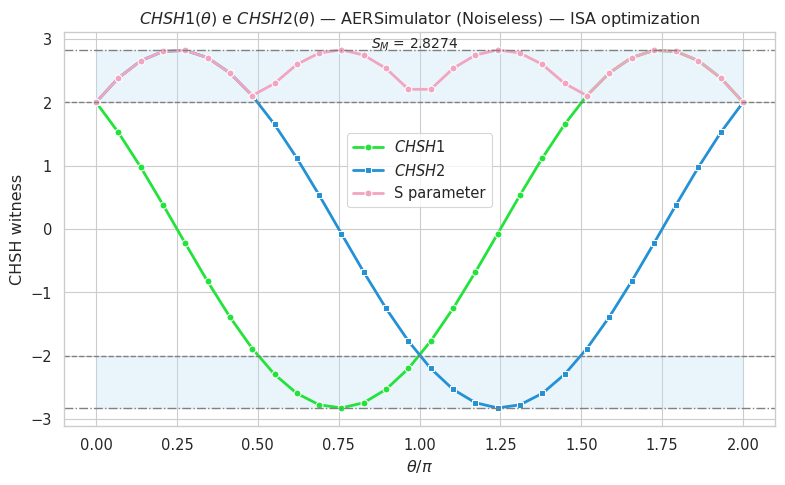

In [ ]:
# ╔═════════╗
# ║ 8. PLOT ║
# ╚═════════╝

sns.set_theme(context='paper', style='whitegrid', palette='bright', font_scale=1.2)
plt.figure(figsize=(8, 5))


# Plot CHSH1 e CHSH2
sns.lineplot(
    x=phases / np.pi,
    y=chsh1_est,
    marker='o',
    linewidth=2,
    label=r'$CHSH1$',
    color='#22e339',
    markersize=5
)
sns.lineplot(
    x=phases / np.pi,
    y=chsh2_est,
    marker='s',
    linewidth=2,
    label=r'$CHSH2$',
    color='#2291d6',
    markersize=5
)
sns.lineplot(x=phases/pi,
             y=S_values,
             marker='o',
             linewidth=2,
             label='S parameter',
             color='#f2a5c0',
             markersize=5)

# Classical limits lines ±2
plt.axhline(y=2, linestyle='--', color='gray', linewidth=1)
plt.axhline(y=-2, linestyle='--', color='gray', linewidth=1)

# Quantum limits lines ±2√2
limit = 2 * np.sqrt(2)
plt.axhline(y=limit, linestyle='-.', color='gray', linewidth=1)
plt.axhline(y=-limit, linestyle='-.', color='gray', linewidth=1)

# Quantum violation regions
plt.fill_between(phases / np.pi, 2, limit, color='#bcdff5', alpha=0.3)
plt.fill_between(phases / np.pi, -2, -limit, color='#bcdff5', alpha=0.3)

# Title & labels
plt.xlabel(r'$\theta / \pi$')
plt.ylabel('CHSH witness')
plt.title(r'$CHSH1(\theta)$ e $CHSH2(\theta)$ — AERSimulator (Noiseless) — ISA optimization')

# Legend & layout
plt.legend(loc="center", bbox_to_anchor=(0.5, 0.65), frameon=True)
plt.tight_layout()

# Max S value show
max_idx = np.argmax(S_values)
plt.annotate(f'$S_M$ = {S_max:.4f}',
             xy=(phases[max_idx]/pi, S_values[max_idx]),
             xytext=(0.85, 2.85),
             fontsize=10)

plt.savefig(
    "AERSIMULATOR_chsh_witness.svg",
    format="svg",
    bbox_inches="tight"
)
plt.show()
